In [23]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model # model
import sys, os
import easydict
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.utils as vutils
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder
from utils import basic
from few_shot_learning_system_Arbiter import MAMLFewShotClassifier
import arbiter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dataset 구성

In [24]:
# choices=['padding', 'random_patch', 'fixed_patch', arbiter],
method = 'arbiter'

datasets = "mini_imagenet"
# datasets = "tiered_imagenet"
# datasets = "CIFAR_FS"
# datasets = "CUB"

os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
# os.environ['TEST_DATASET'] = "tiered_imagenet" # https://mtl.yyliu.net/download/Lmzjm9tX.html
# os.environ['TEST_DATASET'] = "CIFAR_FS" # https://drive.google.com/file/d/1pTsCCMDj45kzFYgrnO67BWVbKs48Q3NI/view
# os.environ['TEST_DATASET'] = "CUB" # https://data.caltech.edu/records/65de6-vp158

In [25]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML_Prompt_arbiter_5way_5shot_filter64_miniImagenet",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":64,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": False,
  "use_bias": True,
  "prompter": True,
  "prompt_engineering": method,
  "prompt_size" : 10,
  "image_size" : 84,
  "prompt_random_init": False,
  "outer_prompt_learning_rate": 0.001,
  "inner_prompt_learning_rate": 0.01,
  "num_text_embedding_params": 100,
  "text_embedding_learning_rate": 1
}
)

device = torch.cuda.current_device()
args.im_shape = (2, 3, args.image_height, args.image_width)

args.use_cuda = torch.cuda.is_available()
args.seed = 104
args.reverse_channels=False
args.labels_as_int=False
args.reset_stored_filepaths=False
args.num_of_gpus=1

args.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


In [26]:
# 모델을 구성한다
model = MAMLFewShotClassifier(args=args, device=device,
                              im_shape=(2, 3,
                                        args.image_height, args.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model, data=data, args=args, device=device)
maml_system.state

Using max pooling
meta network params
Inner Loop parameters
Outer Loop parameters
classifier.prompt.prompt_dict.arbiter torch.Size([3, 84, 84]) cuda:0 True
classifier.layer_dict.conv0.conv.weight torch.Size([64, 3, 3, 3]) cuda:0 True
classifier.layer_dict.conv0.conv.bias torch.Size([64]) cuda:0 True
classifier.layer_dict.conv0.norm_layer.bias torch.Size([64]) cuda:0 True
classifier.layer_dict.conv0.norm_layer.weight torch.Size([64]) cuda:0 True
classifier.layer_dict.conv1.conv.weight torch.Size([64, 64, 3, 3]) cuda:0 True
classifier.layer_dict.conv1.conv.bias torch.Size([64]) cuda:0 True
classifier.layer_dict.conv1.norm_layer.bias torch.Size([64]) cuda:0 True
classifier.layer_dict.conv1.norm_layer.weight torch.Size([64]) cuda:0 True
classifier.layer_dict.conv2.conv.weight torch.Size([64, 64, 3, 3]) cuda:0 True
classifier.layer_dict.conv2.conv.bias torch.Size([64]) cuda:0 True
classifier.layer_dict.conv2.norm_layer.bias torch.Size([64]) cuda:0 True
classifier.layer_dict.conv2.norm_layer

{'best_val_acc': 0.631911111176014,
 'best_val_iter': 27000,
 'current_iter': 50000,
 'best_epoch': 54,
 'train_loss_mean': 0.4740445173382759,
 'train_loss_std': 0.12398248082566049,
 'train_accuracy_mean': 0.8253466676473618,
 'train_accuracy_std': 0.05521948126586835,
 'train_loss_importance_vector_0_mean': 0.006000000052154064,
 'train_loss_importance_vector_0_std': 0.0,
 'train_loss_importance_vector_1_mean': 0.006000000052154064,
 'train_loss_importance_vector_1_std': 0.0,
 'train_loss_importance_vector_2_mean': 0.006000000052154064,
 'train_loss_importance_vector_2_std': 0.0,
 'train_loss_importance_vector_3_mean': 0.006000000052154064,
 'train_loss_importance_vector_3_std': 0.0,
 'train_loss_importance_vector_4_mean': 0.9760000109672546,
 'train_loss_importance_vector_4_std': 0.0,
 'train_learning_rate_mean': 0.0010000000000000005,
 'train_learning_rate_std': 4.336808689942018e-19,
 'val_loss_mean': 1.0318970700105032,
 'val_loss_std': 0.17275102005385354,
 'val_accuracy_mean':

image_np
[[[-0.9997999  -0.8010472  -0.96049505]
  [-0.9999945  -0.9441     -0.9775358 ]
  [-0.99999833 -0.9547363  -0.98211056]
  ...
  [-0.99999964 -0.97193325 -0.9858269 ]
  [-0.99999917 -0.96602035 -0.980716  ]
  [-0.99993724 -0.87662774 -0.9607428 ]]

 [[-0.99999696 -0.8046011  -0.9874774 ]
  [-1.         -0.9544829  -0.99521345]
  [-1.         -0.9577562  -0.99706554]
  ...
  [-1.         -0.9811973  -0.99896306]
  [-1.         -0.977257   -0.99783444]
  [-0.9999996  -0.89962506 -0.9936554 ]]

 [[-0.9999982  -0.8222539  -0.99094343]
  [-1.         -0.9606952  -0.9968557 ]
  [-1.         -0.96028906 -0.9980963 ]
  ...
  [-1.         -0.9849641  -0.9998088 ]
  [-1.         -0.9820128  -0.9994006 ]
  [-0.9999999  -0.9133956  -0.99700975]]

 ...

 [[-0.999998   -0.818609   -0.98905474]
  [-1.         -0.9579596  -0.9938281 ]
  [-1.         -0.9507034  -0.99201417]
  ...
  [-1.         -0.9307948  -0.99350464]
  [-1.         -0.9536669  -0.993161  ]
  [-0.999999   -0.8714092  -0.98895

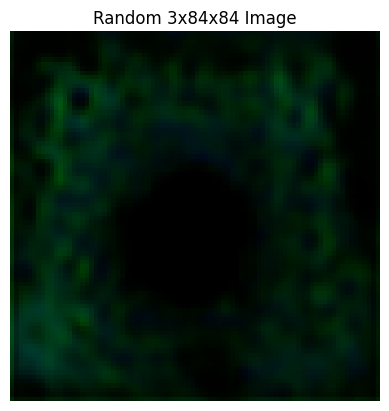

image_np
[[[-0.9998558  -0.8126323  -0.9603069 ]
  [-0.9999967  -0.9499556  -0.97646904]
  [-0.99999905 -0.9573973  -0.98037195]
  ...
  [-0.9999997  -0.97279286 -0.9834456 ]
  [-0.9999993  -0.96688366 -0.97807235]
  [-0.9999412  -0.87852937 -0.9573342 ]]

 [[-0.99999815 -0.8193655  -0.98763657]
  [-1.         -0.96085644 -0.99503094]
  [-1.         -0.961045   -0.9967954 ]
  ...
  [-1.         -0.9827164  -0.9987472 ]
  [-1.         -0.97852767 -0.9975107 ]
  [-0.99999964 -0.9022093  -0.9930957 ]]

 [[-0.999999   -0.8377606  -0.9910773 ]
  [-1.         -0.9668793  -0.9967434 ]
  [-1.         -0.96438867 -0.99797934]
  ...
  [-1.         -0.9868952  -0.9997997 ]
  [-1.         -0.9835587  -0.9993968 ]
  [-0.9999999  -0.9164987  -0.99704707]]

 ...

 [[-0.9999991  -0.84519595 -0.99230915]
  [-1.         -0.9672295  -0.99630016]
  [-1.         -0.9626473  -0.99492484]
  ...
  [-1.         -0.92290217 -0.98718494]
  [-1.         -0.9497125  -0.9874455 ]
  [-0.9999986  -0.865421   -0.98292

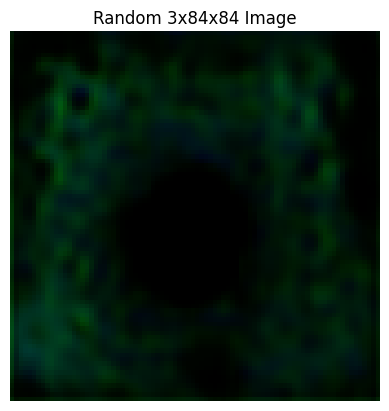

image_np
[[[-0.9998812  -0.8262081  -0.96172386]
  [-0.99999744 -0.9548282  -0.97722715]
  [-0.99999917 -0.95956564 -0.9806852 ]
  ...
  [-0.9999997  -0.97294945 -0.9844729 ]
  [-0.9999992  -0.9663863  -0.9789748 ]
  [-0.99993813 -0.8768809  -0.95801103]]

 [[-0.9999987  -0.8392786  -0.9883846 ]
  [-1.         -0.9662401  -0.9953854 ]
  [-1.         -0.96388227 -0.9969502 ]
  ...
  [-1.         -0.9829069  -0.99889743]
  [-1.         -0.9780777  -0.9976939 ]
  [-0.99999964 -0.9004203  -0.9932584 ]]

 [[-0.9999993  -0.8574525  -0.9918707 ]
  [-1.         -0.97136843 -0.9971554 ]
  [-1.         -0.96688044 -0.9981871 ]
  ...
  [-1.         -0.9872076  -0.9998296 ]
  [-1.         -0.98327875 -0.9994481 ]
  [-0.9999999  -0.91518724 -0.9971056 ]]

 ...

 [[-0.9999987  -0.831074   -0.9907827 ]
  [-1.         -0.9635056  -0.9952971 ]
  [-1.         -0.9581914  -0.9942141 ]
  ...
  [-1.         -0.93101525 -0.9894313 ]
  [-1.         -0.95324403 -0.9898734 ]
  [-0.9999991  -0.86684567 -0.98582

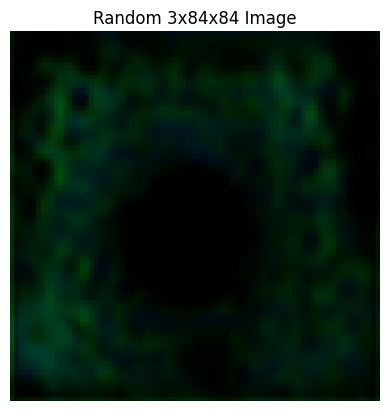

image_np
[[[-0.9998621  -0.82429814 -0.96563417]
  [-0.9999966  -0.95305145 -0.98113585]
  [-0.9999988  -0.9589042  -0.9840281 ]
  ...
  [-0.99999964 -0.9692739  -0.981732  ]
  [-0.9999991  -0.963762   -0.9768836 ]
  [-0.99993473 -0.87178737 -0.9565672 ]]

 [[-0.99999845 -0.83446807 -0.99042153]
  [-1.         -0.96317565 -0.9967605 ]
  [-1.         -0.96155    -0.9978678 ]
  ...
  [-1.         -0.98022926 -0.9983293 ]
  [-1.         -0.9764493  -0.9969813 ]
  [-0.9999996  -0.8964801  -0.9923924 ]]

 [[-0.9999992  -0.8547114  -0.99345464]
  [-1.         -0.96894515 -0.9981163 ]
  [-1.         -0.96433765 -0.99880147]
  ...
  [-1.         -0.9845212  -0.999694  ]
  [-1.         -0.98158705 -0.99918574]
  [-0.9999998  -0.9106619  -0.99651635]]

 ...

 [[-0.9999978  -0.8089547  -0.98778003]
  [-1.         -0.9566698  -0.9920363 ]
  [-1.         -0.9512969  -0.9884456 ]
  ...
  [-1.         -0.9325907  -0.9922919 ]
  [-1.         -0.9537822  -0.99228007]
  [-0.999999   -0.8692656  -0.98812

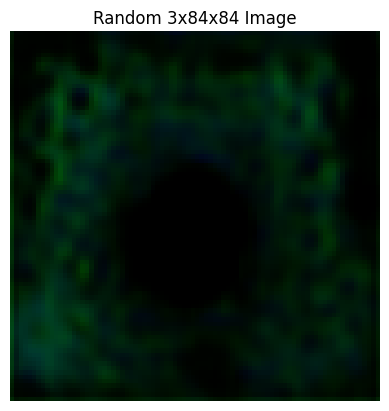

image_np
[[[-0.99983925 -0.8064263  -0.9574731 ]
  [-0.99999624 -0.94785154 -0.97423106]
  [-0.9999989  -0.9563221  -0.97905076]
  ...
  [-0.9999997  -0.97252303 -0.9861287 ]
  [-0.9999993  -0.9669727  -0.98133636]
  [-0.9999421  -0.87878036 -0.9615462 ]]

 [[-0.99999785 -0.8146483  -0.9861826 ]
  [-1.         -0.95980996 -0.99418086]
  [-1.         -0.9605256  -0.99639696]
  ...
  [-1.         -0.98198384 -0.99907374]
  [-1.         -0.97829247 -0.99814236]
  [-0.99999964 -0.90202045 -0.9943451 ]]

 [[-0.9999988  -0.8351015  -0.99015677]
  [-1.         -0.966307   -0.9962845 ]
  [-1.         -0.96415    -0.997814  ]
  ...
  [-1.         -0.98601586 -0.99985844]
  [-1.         -0.983302   -0.9995754 ]
  [-0.9999999  -0.91639024 -0.9976906 ]]

 ...

 [[-0.999999   -0.83854634 -0.9887503 ]
  [-1.         -0.965472   -0.9930562 ]
  [-1.         -0.95514363 -0.99012536]
  ...
  [-1.         -0.9182802  -0.9837942 ]
  [-1.         -0.9433369  -0.98399585]
  [-0.9999979  -0.85534763 -0.97921

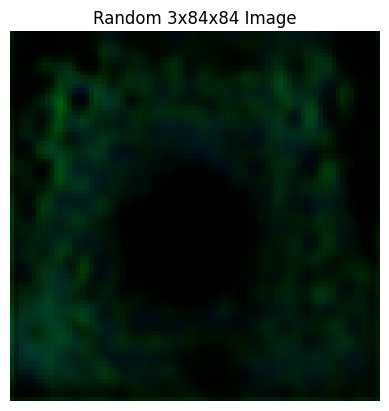

image_np
[[[-0.9998855  -0.8226497  -0.96438724]
  [-0.99999774 -0.95415926 -0.97981673]
  [-0.99999934 -0.9608772  -0.98314404]
  ...
  [-0.99999976 -0.97377056 -0.98510355]
  [-0.99999934 -0.96662116 -0.97931826]
  [-0.999943   -0.87592626 -0.95850235]]

 [[-0.99999875 -0.83135575 -0.9894779 ]
  [-1.         -0.9643688  -0.9961234 ]
  [-1.         -0.9640627  -0.99753416]
  ...
  [-1.         -0.98321676 -0.998939  ]
  [-1.         -0.97774136 -0.99771595]
  [-0.9999997  -0.89765894 -0.9933309 ]]

 [[-0.99999934 -0.84733415 -0.9923742 ]
  [-1.         -0.96914166 -0.997499  ]
  [-1.         -0.96636075 -0.9984864 ]
  ...
  [-1.         -0.987165   -0.99981207]
  [-1.         -0.9826589  -0.99939567]
  [-0.9999999  -0.9113345  -0.9969942 ]]

 ...

 [[-0.9999987  -0.8336177  -0.99123865]
  [-1.         -0.962801   -0.99534446]
  [-1.         -0.9568729  -0.9933216 ]
  ...
  [-1.         -0.93179435 -0.98903567]
  [-1.         -0.951164   -0.98875654]
  [-0.9999989  -0.8638157  -0.98400

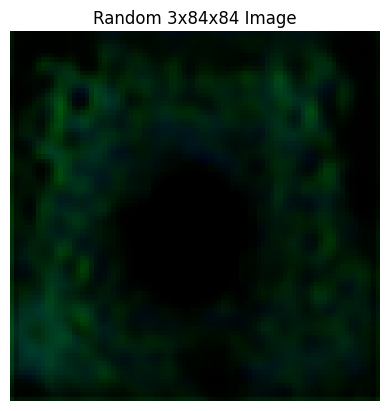

image_np
[[[-0.99988544 -0.8278483  -0.9641576 ]
  [-0.9999978  -0.95679724 -0.980539  ]
  [-0.9999994  -0.96444076 -0.9847774 ]
  ...
  [-0.9999998  -0.9770236  -0.9893261 ]
  [-0.99999946 -0.96942085 -0.98363364]
  [-0.9999489  -0.88117754 -0.96275324]]

 [[-0.99999875 -0.8367682  -0.9894712 ]
  [-1.         -0.9670217  -0.9964046 ]
  [-1.         -0.9688565  -0.9979665 ]
  ...
  [-1.         -0.9851956  -0.99949133]
  [-1.         -0.9794176  -0.9986662 ]
  [-0.9999997  -0.90205127 -0.99493533]]

 [[-0.9999993  -0.851064   -0.99206257]
  [-1.         -0.97153443 -0.99757016]
  [-1.         -0.9717818  -0.99872106]
  ...
  [-1.         -0.98874503 -0.99993086]
  [-1.         -0.9840154  -0.9997107 ]
  [-0.99999994 -0.9160516  -0.99794865]]

 ...

 [[-0.9999983  -0.8163966  -0.9895296 ]
  [-1.         -0.9579043  -0.9938106 ]
  [-1.         -0.95267445 -0.99063516]
  ...
  [-1.         -0.92636615 -0.98706615]
  [-1.         -0.95192087 -0.98705435]
  [-0.99999905 -0.8670885  -0.98224

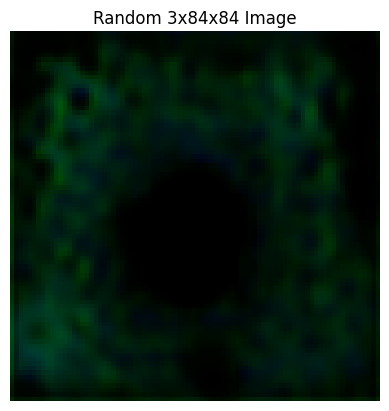

image_np
[[[-0.99982405 -0.8078827  -0.95926166]
  [-0.9999959  -0.94879645 -0.97711056]
  [-0.99999887 -0.96001625 -0.98300713]
  ...
  [-0.9999997  -0.9774433  -0.9928913 ]
  [-0.99999917 -0.97139    -0.98792   ]
  [-0.99993485 -0.89114124 -0.9678182 ]]

 [[-0.9999975  -0.814025   -0.98701143]
  [-1.         -0.96004385 -0.99513966]
  [-1.         -0.964607   -0.9973924 ]
  ...
  [-1.         -0.984433   -0.99984205]
  [-1.         -0.9805586  -0.99943155]
  [-0.9999996  -0.9142185  -0.9966472 ]]

 [[-0.9999986  -0.8326488  -0.99048394]
  [-1.         -0.96644    -0.9967566 ]
  [-1.         -0.96866107 -0.99833876]
  ...
  [-1.         -0.988326   -0.9999932 ]
  [-1.         -0.98548436 -0.999945  ]
  [-0.9999999  -0.93083763 -0.9990504 ]]

 ...

 [[-0.9999962  -0.78524727 -0.98434377]
  [-1.         -0.9490141  -0.9885342 ]
  [-1.         -0.94597775 -0.9836113 ]
  ...
  [-1.         -0.9365169  -0.99301857]
  [-1.         -0.95468694 -0.99210197]
  [-0.9999988  -0.8707713  -0.98693

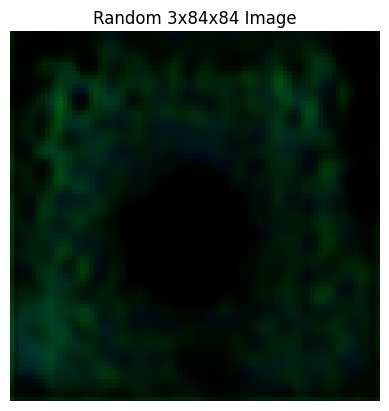

image_np
[[[-0.9998276  -0.80470026 -0.96052265]
  [-0.9999958  -0.94674814 -0.97750187]
  [-0.9999988  -0.9570596  -0.98234093]
  ...
  [-0.99999976 -0.97602355 -0.9906913 ]
  [-0.99999934 -0.9697768  -0.9859709 ]
  [-0.9999419  -0.88522196 -0.9666969 ]]

 [[-0.9999976  -0.8101356  -0.98752564]
  [-1.         -0.9576859  -0.99520886]
  [-1.         -0.96033436 -0.9971608 ]
  ...
  [-1.         -0.98381966 -0.99962837]
  [-1.         -0.979705   -0.99903035]
  [-0.9999997  -0.9076852  -0.9959363 ]]

 [[-0.9999987  -0.82916325 -0.9908734 ]
  [-1.         -0.9639651  -0.9967981 ]
  [-1.         -0.9631253  -0.9981536 ]
  ...
  [-1.         -0.9877303  -0.9999625 ]
  [-1.         -0.98472303 -0.9998328 ]
  [-0.9999999  -0.92340684 -0.9985338 ]]

 ...

 [[-0.99999785 -0.81585926 -0.9884641 ]
  [-1.         -0.95580715 -0.9929237 ]
  [-1.         -0.9465683  -0.98939204]
  ...
  [-1.         -0.9251551  -0.9882944 ]
  [-1.         -0.9512623  -0.98868346]
  [-0.9999987  -0.8689287  -0.98421

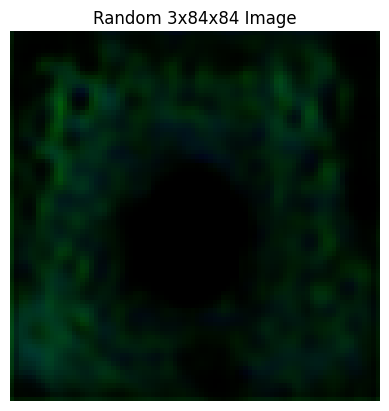

image_np
[[[-0.9998461  -0.80674994 -0.95979047]
  [-0.99999654 -0.9477727  -0.9765278 ]
  [-0.99999905 -0.9572185  -0.9810731 ]
  ...
  [-0.99999976 -0.9749414  -0.9900068 ]
  [-0.9999993  -0.9682505  -0.98492986]
  [-0.99993867 -0.8803108  -0.9648032 ]]

 [[-0.99999803 -0.8157748  -0.9875852 ]
  [-1.         -0.9597165  -0.9951212 ]
  [-1.         -0.9615292  -0.9970095 ]
  ...
  [-1.         -0.98393184 -0.99958897]
  [-1.         -0.9792487  -0.9989018 ]
  [-0.99999964 -0.9040482  -0.99548507]]

 [[-0.99999905 -0.8385952  -0.9914586 ]
  [-1.         -0.966969   -0.99703985]
  [-1.         -0.9657482  -0.99826545]
  ...
  [-1.         -0.98800707 -0.9999656 ]
  [-1.         -0.9843565  -0.9998321 ]
  [-0.9999999  -0.92008907 -0.9984399 ]]

 ...

 [[-0.99999785 -0.8138986  -0.98834544]
  [-1.         -0.95843786 -0.99328583]
  [-1.         -0.9544088  -0.9919558 ]
  ...
  [-1.         -0.9149523  -0.9849835 ]
  [-1.         -0.94415647 -0.9856851 ]
  [-0.9999986  -0.8564417  -0.98136

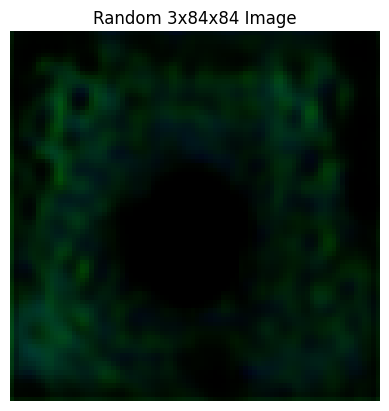

image_np
[[[-0.9998604  -0.8259395  -0.961841  ]
  [-0.99999684 -0.9552684  -0.97863096]
  [-0.99999905 -0.96264446 -0.9833256 ]
  ...
  [-0.99999964 -0.97572786 -0.9896496 ]
  [-0.99999917 -0.9698678  -0.98394763]
  [-0.9999344  -0.8877768  -0.9623162 ]]

 [[-0.99999833 -0.83516586 -0.9888381 ]
  [-1.         -0.964901   -0.9960471 ]
  [-1.         -0.965155   -0.9977344 ]
  ...
  [-1.         -0.983935   -0.9996298 ]
  [-1.         -0.9799006  -0.9989273 ]
  [-0.9999996  -0.91077715 -0.99526024]]

 [[-0.99999917 -0.85412025 -0.99206823]
  [-1.         -0.9701707  -0.9975292 ]
  [-1.         -0.9678923  -0.9986278 ]
  ...
  [-1.         -0.9884773  -0.9999733 ]
  [-1.         -0.98512626 -0.9998504 ]
  [-0.9999999  -0.9265913  -0.99841243]]

 ...

 [[-0.99999857 -0.8292471  -0.9898894 ]
  [-1.         -0.96231    -0.99432534]
  [-1.         -0.9564025  -0.991873  ]
  ...
  [-1.         -0.93610847 -0.99166626]
  [-1.         -0.9585571  -0.9920029 ]
  [-0.9999994  -0.87770617 -0.98814

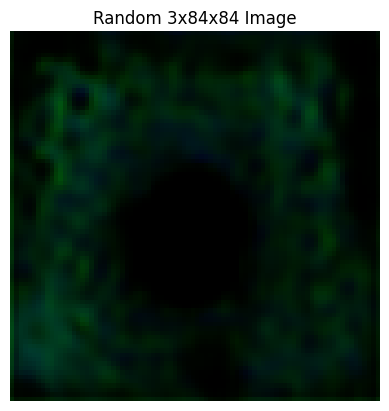

image_np
[[[-0.9998648  -0.81915414 -0.96490365]
  [-0.9999971  -0.95244795 -0.98099345]
  [-0.99999917 -0.96067    -0.98490745]
  ...
  [-0.9999997  -0.97027224 -0.9849226 ]
  [-0.9999992  -0.9633931  -0.9797823 ]
  [-0.99993616 -0.86944175 -0.9595212 ]]

 [[-0.9999984  -0.8282164  -0.9896727 ]
  [-1.         -0.9632164  -0.9964304 ]
  [-1.         -0.9646471  -0.99787736]
  ...
  [-1.         -0.9805227  -0.9988048 ]
  [-1.         -0.9753765  -0.9975908 ]
  [-0.9999996  -0.89150167 -0.9932017 ]]

 [[-0.99999917 -0.8460867  -0.9925122 ]
  [-1.         -0.96877134 -0.99768   ]
  [-1.         -0.9677579  -0.9986723 ]
  ...
  [-1.         -0.9849595  -0.9997559 ]
  [-1.         -0.9807259  -0.9992865 ]
  [-0.9999999  -0.9053077  -0.99672043]]

 ...

 [[-0.99999624 -0.78558505 -0.98372537]
  [-1.         -0.95032793 -0.9879029 ]
  [-1.         -0.9485302  -0.9831099 ]
  ...
  [-1.         -0.9174595  -0.9876622 ]
  [-1.         -0.9482479  -0.9879923 ]
  [-0.99999857 -0.86654645 -0.98332

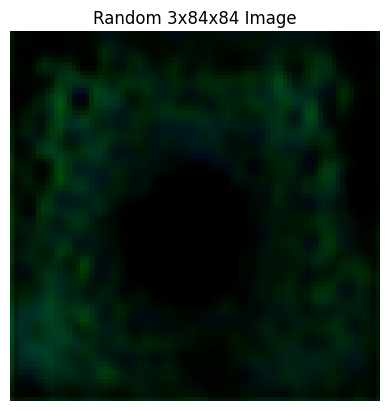

image_np
[[[-0.99980074 -0.79350626 -0.95702314]
  [-0.99999475 -0.941239   -0.9740498 ]
  [-0.99999845 -0.95156306 -0.9788289 ]
  ...
  [-0.9999994  -0.9691402  -0.98747003]
  [-0.9999987  -0.96398336 -0.98264915]
  [-0.99991393 -0.8750838  -0.96283174]]

 [[-0.9999968  -0.79332983 -0.9853264 ]
  [-1.         -0.9514505  -0.99361587]
  [-1.         -0.9540006  -0.99588484]
  ...
  [-1.         -0.9785663  -0.9992582 ]
  [-1.         -0.9752776  -0.9983581 ]
  [-0.99999934 -0.89792293 -0.9944883 ]]

 [[-0.999998   -0.80709344 -0.988736  ]
  [-1.         -0.9571073  -0.9953119 ]
  [-1.         -0.9561029  -0.99698484]
  ...
  [-1.         -0.98327434 -0.99990714]
  [-1.         -0.98084766 -0.9996609 ]
  [-0.99999976 -0.9133111  -0.9977338 ]]

 ...

 [[-0.99999857 -0.8293791  -0.9908841 ]
  [-1.         -0.96209705 -0.99518347]
  [-1.         -0.9559779  -0.993433  ]
  ...
  [-1.         -0.93670917 -0.9953466 ]
  [-1.         -0.95611197 -0.9949626 ]
  [-0.999999   -0.87135774 -0.99114

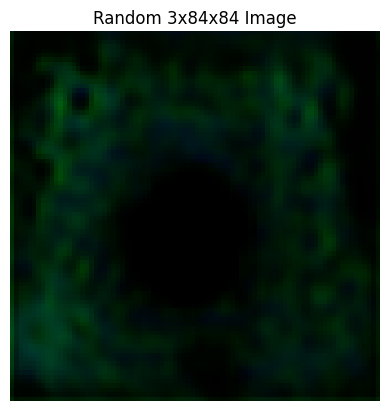

image_np
[[[-0.9998836  -0.8316264  -0.96484065]
  [-0.9999977  -0.9578768  -0.9805443 ]
  [-0.99999934 -0.96496254 -0.98441434]
  ...
  [-0.99999976 -0.9753152  -0.9902936 ]
  [-0.9999993  -0.96843493 -0.9854772 ]
  [-0.9999406  -0.88067967 -0.96594155]]

 [[-0.99999875 -0.84320617 -0.9900075 ]
  [-1.         -0.96811455 -0.9965435 ]
  [-1.         -0.9690095  -0.9979585 ]
  ...
  [-1.         -0.98473    -0.99959725]
  [-1.         -0.9798672  -0.9989483 ]
  [-0.9999997  -0.90530217 -0.99571335]]

 [[-0.99999934 -0.8610865  -0.9930748 ]
  [-1.         -0.9729248  -0.9979322 ]
  [-1.         -0.9717675  -0.998841  ]
  ...
  [-1.         -0.98914415 -0.9999642 ]
  [-1.         -0.9852931  -0.999833  ]
  [-0.9999999  -0.92196    -0.99852115]]

 ...

 [[-0.99999654 -0.7924606  -0.9825077 ]
  [-1.         -0.95124966 -0.9864322 ]
  [-1.         -0.94377    -0.98087215]
  ...
  [-1.         -0.9339511  -0.98848295]
  [-1.         -0.9544765  -0.98864836]
  [-0.9999991  -0.87019217 -0.98429

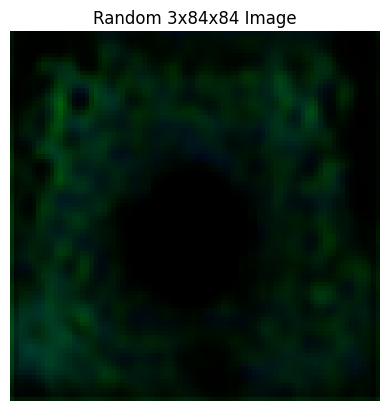

image_np
[[[-0.99983907 -0.8077808  -0.9573517 ]
  [-0.9999963  -0.9481411  -0.97451556]
  [-0.999999   -0.95699155 -0.97962594]
  ...
  [-0.9999998  -0.97717404 -0.99288696]
  [-0.9999994  -0.97062355 -0.9884702 ]
  [-0.999946   -0.8857045  -0.9696959 ]]

 [[-0.9999978  -0.8132921  -0.9863495 ]
  [-1.         -0.9589582  -0.9944022 ]
  [-1.         -0.96038854 -0.9965941 ]
  ...
  [-1.         -0.98511124 -0.99979013]
  [-1.         -0.9806364  -0.9993732 ]
  [-0.9999997  -0.90842515 -0.99678266]]

 [[-0.99999875 -0.8313605  -0.99021864]
  [-1.         -0.96484256 -0.9963849 ]
  [-1.         -0.963464   -0.99788606]
  ...
  [-1.         -0.9889281  -0.999985  ]
  [-1.         -0.98556256 -0.9999176 ]
  [-0.99999994 -0.9243988  -0.99900764]]

 ...

 [[-0.9999981  -0.82412326 -0.9886689 ]
  [-1.         -0.9597219  -0.9933982 ]
  [-1.         -0.9525124  -0.9907555 ]
  ...
  [-1.         -0.9359594  -0.987502  ]
  [-1.         -0.9576253  -0.9879563 ]
  [-0.99999934 -0.87566864 -0.98372

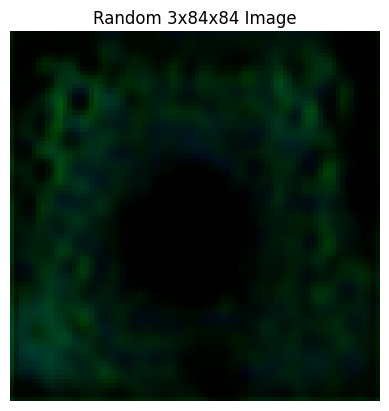

image_np
[[[-0.99988085 -0.82413185 -0.9672378 ]
  [-0.9999975  -0.95385647 -0.9829915 ]
  [-0.9999992  -0.9608208  -0.98631155]
  ...
  [-0.99999964 -0.9714055  -0.98661923]
  [-0.9999991  -0.9659786  -0.98150903]
  [-0.9999338  -0.8778063  -0.960738  ]]

 [[-0.99999875 -0.8365948  -0.99097276]
  [-1.         -0.9650999  -0.99719125]
  [-1.         -0.9650045  -0.99834204]
  ...
  [-1.         -0.9808063  -0.9991915 ]
  [-1.         -0.9772325  -0.9982341 ]
  [-0.9999996  -0.90086013 -0.9941654 ]]

 [[-0.9999994  -0.8581015  -0.99371296]
  [-1.         -0.9715275  -0.9983383 ]
  [-1.         -0.96896374 -0.99908996]
  ...
  [-1.         -0.98516494 -0.9998923 ]
  [-1.         -0.9823703  -0.9996224 ]
  [-0.9999998  -0.91541475 -0.99761605]]

 ...

 [[-0.99999744 -0.80590653 -0.9849863 ]
  [-1.         -0.9537642  -0.9890252 ]
  [-1.         -0.94374806 -0.98259515]
  ...
  [-1.         -0.9212569  -0.9884632 ]
  [-1.         -0.9484955  -0.9884505 ]
  [-0.99999857 -0.8634589  -0.98372

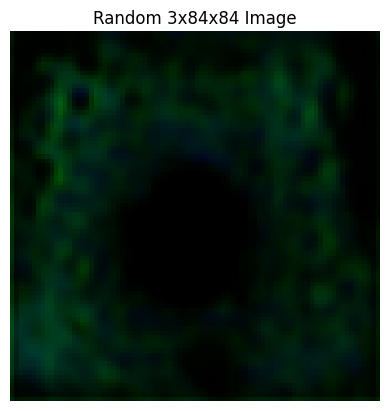

image_np
[[[-0.9998857  -0.8304308  -0.96633047]
  [-0.9999978  -0.9575121  -0.98252875]
  [-0.9999994  -0.96566695 -0.9866345 ]
  ...
  [-0.99999964 -0.9741712  -0.9873603 ]
  [-0.99999917 -0.9674084  -0.9818008 ]
  [-0.99993366 -0.8800596  -0.9601575 ]]

 [[-0.9999988  -0.8424679  -0.99074495]
  [-1.         -0.96829283 -0.99715227]
  [-1.         -0.9706492  -0.99847996]
  ...
  [-1.         -0.9833851  -0.99938107]
  [-1.         -0.9785144  -0.9984777 ]
  [-0.9999996  -0.9039458  -0.99437875]]

 [[-0.99999946 -0.8620903  -0.993576  ]
  [-1.         -0.97418183 -0.99832994]
  [-1.         -0.9749424  -0.99919695]
  ...
  [-1.         -0.98769605 -0.9999427 ]
  [-1.         -0.9837978  -0.99974686]
  [-0.9999998  -0.9201401  -0.9979516 ]]

 ...

 [[-0.99999857 -0.8238826  -0.9908397 ]
  [-1.         -0.96229964 -0.99523383]
  [-1.         -0.9613704  -0.99405915]
  ...
  [-1.         -0.9309037  -0.99119157]
  [-1.         -0.9537101  -0.9903968 ]
  [-0.999999   -0.87023926 -0.98503

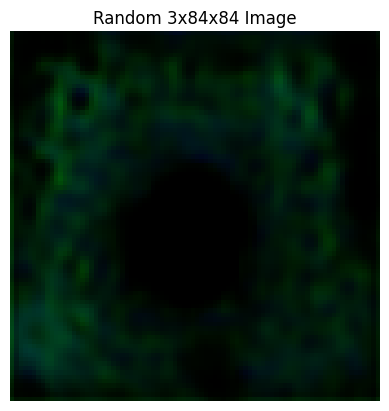

image_np
[[[-0.9997846  -0.7929323  -0.95084167]
  [-0.9999942  -0.9413482  -0.96820635]
  [-0.99999833 -0.9517429  -0.9737769 ]
  ...
  [-0.9999996  -0.97176135 -0.9866897 ]
  [-0.99999905 -0.96704525 -0.98099625]
  [-0.9999325  -0.8818348  -0.95940965]]

 [[-0.99999636 -0.79359615 -0.9828327 ]
  [-1.         -0.9521445  -0.99184066]
  [-1.         -0.95487213 -0.9947047 ]
  ...
  [-1.         -0.9811334  -0.99926174]
  [-1.         -0.9782835  -0.9982548 ]
  [-0.9999996  -0.9057882  -0.99400383]]

 [[-0.9999978  -0.8112373  -0.9873678 ]
  [-1.         -0.95908743 -0.9944332 ]
  [-1.         -0.9588363  -0.99649704]
  ...
  [-1.         -0.9854413  -0.9999192 ]
  [-1.         -0.9833212  -0.99967086]
  [-0.9999998  -0.9205115  -0.997666  ]]

 ...

 [[-0.999999   -0.84154963 -0.98935294]
  [-1.         -0.9655623  -0.9940119 ]
  [-1.         -0.9560228  -0.99200976]
  ...
  [-1.         -0.9093419  -0.98244345]
  [-1.         -0.9410733  -0.98273516]
  [-0.9999979  -0.8548851  -0.97782

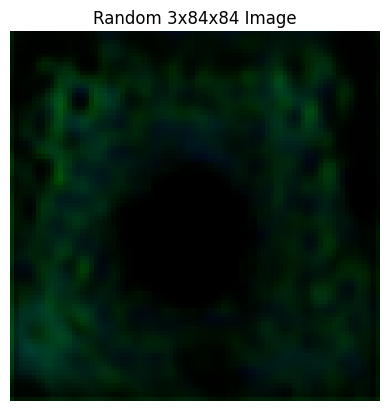

image_np
[[[-0.99987054 -0.82351035 -0.96390593]
  [-0.99999714 -0.9541319  -0.97927594]
  [-0.9999991  -0.9608411  -0.9825596 ]
  ...
  [-0.99999976 -0.97312355 -0.9893555 ]
  [-0.9999993  -0.96574813 -0.9848181 ]
  [-0.99993795 -0.8735508  -0.9662533 ]]

 [[-0.9999985  -0.83520085 -0.98944056]
  [-1.         -0.9653763  -0.99607956]
  [-1.         -0.9655701  -0.9974651 ]
  ...
  [-1.         -0.9831655  -0.999415  ]
  [-1.         -0.97762036 -0.9986892 ]
  [-0.99999964 -0.8967301  -0.9954482 ]]

 [[-0.9999992  -0.8541422  -0.9928221 ]
  [-1.         -0.97078466 -0.99771875]
  [-1.         -0.9688048  -0.9986137 ]
  ...
  [-1.         -0.9877719  -0.99992037]
  [-1.         -0.9833223  -0.9997279 ]
  [-0.9999999  -0.9123435  -0.9982598 ]]

 ...

 [[-0.9999983  -0.8190934  -0.98857856]
  [-1.         -0.96050537 -0.9929391 ]
  [-1.         -0.9557192  -0.9908992 ]
  ...
  [-1.         -0.9372181  -0.9918341 ]
  [-1.         -0.95348424 -0.9914719 ]
  [-0.9999991  -0.86333394 -0.98729

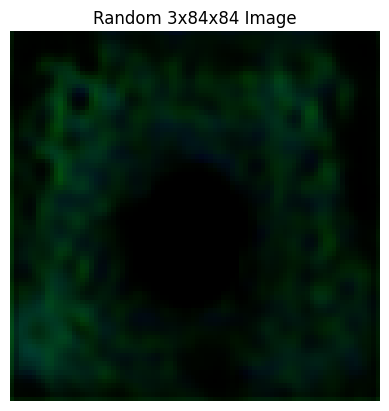

image_np
[[[-0.9998938  -0.8338876  -0.96669006]
  [-0.9999979  -0.95795107 -0.9826008 ]
  [-0.99999934 -0.96376485 -0.9864331 ]
  ...
  [-0.9999996  -0.9732259  -0.98902696]
  [-0.99999905 -0.9675285  -0.983949  ]
  [-0.9999298  -0.8823635  -0.9633358 ]]

 [[-0.999999   -0.8485886  -0.9907597 ]
  [-1.         -0.9689788  -0.99710137]
  [-1.         -0.96820056 -0.998367  ]
  ...
  [-1.         -0.9819318  -0.999524  ]
  [-1.         -0.97814214 -0.99880207]
  [-0.9999995  -0.90555775 -0.995199  ]]

 [[-0.9999995  -0.86880445 -0.9935683 ]
  [-1.         -0.9746407  -0.9982832 ]
  [-1.         -0.9719699  -0.99909115]
  ...
  [-1.         -0.9865308  -0.99995714]
  [-1.         -0.9835872  -0.99980706]
  [-0.9999998  -0.9216651  -0.998284  ]]

 ...

 [[-0.9999983  -0.8223876  -0.98946714]
  [-1.         -0.95921695 -0.99407697]
  [-1.         -0.95317906 -0.9918178 ]
  ...
  [-1.         -0.92952585 -0.99327725]
  [-1.         -0.9521513  -0.99263704]
  [-0.9999989  -0.86754215 -0.98805

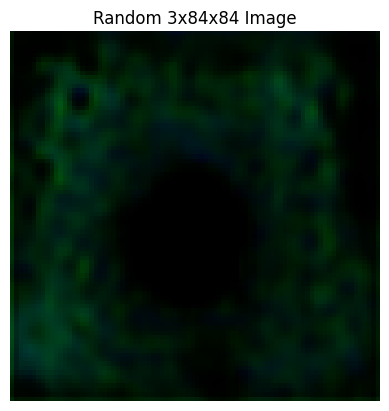

image_np
[[[-0.99988717 -0.8300728  -0.96385413]
  [-0.9999977  -0.95621496 -0.9795209 ]
  [-0.9999993  -0.96164966 -0.98285896]
  ...
  [-0.9999998  -0.9761587  -0.98716736]
  [-0.9999994  -0.9691165  -0.98177433]
  [-0.999948   -0.88145876 -0.96065915]]

 [[-0.9999988  -0.8391594  -0.9897339 ]
  [-1.         -0.9653973  -0.99633616]
  [-1.         -0.96360433 -0.99764603]
  ...
  [-1.         -0.98543686 -0.9993131 ]
  [-1.         -0.9804871  -0.9983919 ]
  [-0.9999997  -0.90610707 -0.99440837]]

 [[-0.99999934 -0.85532945 -0.99277693]
  [-1.         -0.96970487 -0.9977595 ]
  [-1.         -0.96542525 -0.9985958 ]
  ...
  [-1.         -0.98928756 -0.99992365]
  [-1.         -0.9854662  -0.99969697]
  [-0.99999994 -0.92197376 -0.9978816 ]]

 ...

 [[-0.99999845 -0.82499546 -0.9911871 ]
  [-1.         -0.9622688  -0.99554855]
  [-1.         -0.9618869  -0.99441653]
  ...
  [-1.         -0.9273378  -0.99128914]
  [-1.         -0.9503851  -0.9907044 ]
  [-0.99999887 -0.86526334 -0.98549

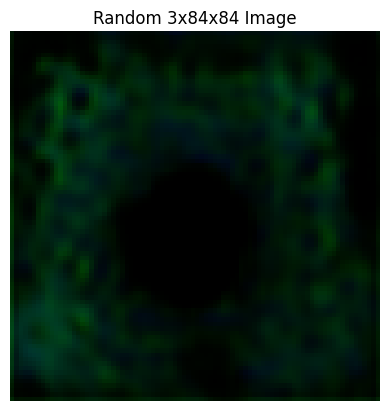

image_np
[[[-0.9998294  -0.80822    -0.95887554]
  [-0.999996   -0.94862634 -0.9757493 ]
  [-0.9999989  -0.9589322  -0.98049307]
  ...
  [-0.9999997  -0.97377557 -0.9852482 ]
  [-0.9999992  -0.9677051  -0.9799581 ]
  [-0.9999368  -0.8808197  -0.95879364]]

 [[-0.99999774 -0.8155326  -0.98726356]
  [-1.         -0.9598188  -0.99493814]
  [-1.         -0.9625461  -0.9969087 ]
  ...
  [-1.         -0.9836683  -0.99910283]
  [-1.         -0.97938395 -0.99807405]
  [-0.99999964 -0.90536344 -0.9938678 ]]

 [[-0.99999887 -0.83811736 -0.9910313 ]
  [-1.         -0.9669762  -0.99679047]
  [-1.         -0.96619564 -0.99809   ]
  ...
  [-1.         -0.9879812  -0.99989563]
  [-1.         -0.9845419  -0.99963033]
  [-0.9999999  -0.9205634  -0.99766004]]

 ...

 [[-0.99999315 -0.7591392  -0.977064  ]
  [-0.99999994 -0.93643844 -0.9796878 ]
  [-1.         -0.9288581  -0.9682701 ]
  ...
  [-1.         -0.9277161  -0.9895589 ]
  [-1.         -0.95272356 -0.9896199 ]
  [-0.99999887 -0.8705059  -0.98480

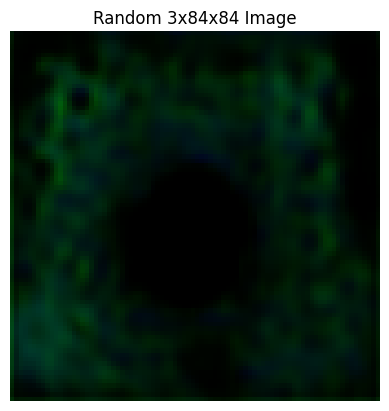

image_np
[[[-0.99987787 -0.8238175  -0.9658077 ]
  [-0.9999975  -0.95495063 -0.9811833 ]
  [-0.99999934 -0.9628125  -0.98469687]
  ...
  [-0.99999976 -0.97388923 -0.9865658 ]
  [-0.9999994  -0.9673252  -0.98171836]
  [-0.999949   -0.87704194 -0.96237177]]

 [[-0.9999986  -0.83062506 -0.9901248 ]
  [-1.         -0.9642542  -0.9965286 ]
  [-1.         -0.96545327 -0.9978611 ]
  ...
  [-1.         -0.98419756 -0.99907863]
  [-1.         -0.979404   -0.99813557]
  [-0.99999976 -0.9011593  -0.9944589 ]]

 [[-0.9999992  -0.8456996  -0.992792  ]
  [-1.         -0.9685229  -0.99771047]
  [-1.         -0.96707404 -0.99862057]
  ...
  [-1.         -0.98845214 -0.9998523 ]
  [-1.         -0.98454225 -0.9995636 ]
  [-0.99999994 -0.9153232  -0.99776685]]

 ...

 [[-0.9999985  -0.8277937  -0.99161583]
  [-1.         -0.96055865 -0.99566466]
  [-1.         -0.9557261  -0.9934802 ]
  ...
  [-1.         -0.93747365 -0.9928191 ]
  [-1.         -0.95684516 -0.99274147]
  [-0.9999993  -0.871169   -0.98878

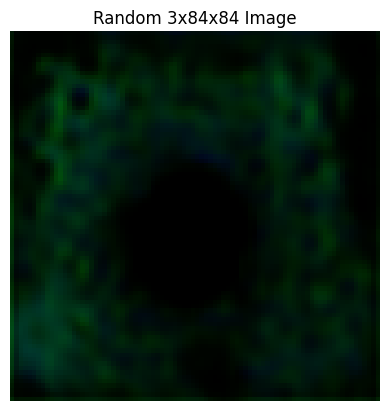

image_np
[[[-0.9998692  -0.8191253  -0.9653377 ]
  [-0.99999726 -0.95206916 -0.9820411 ]
  [-0.9999992  -0.9601608  -0.9863569 ]
  ...
  [-0.9999998  -0.97536325 -0.9881284 ]
  [-0.99999946 -0.9687326  -0.9828897 ]
  [-0.9999508  -0.8807483  -0.9624624 ]]

 [[-0.9999985  -0.82860506 -0.98997366]
  [-1.         -0.96296424 -0.996801  ]
  [-1.         -0.96424294 -0.998244  ]
  ...
  [-1.         -0.9840925  -0.9993589 ]
  [-1.         -0.979566   -0.99850136]
  [-0.99999976 -0.903752   -0.9947725 ]]

 [[-0.9999992  -0.84713465 -0.99284303]
  [-1.         -0.968701   -0.99800044]
  [-1.         -0.96772397 -0.99896365]
  ...
  [-1.         -0.98781574 -0.9999116 ]
  [-1.         -0.98442405 -0.9996755 ]
  [-0.99999994 -0.9185354  -0.997916  ]]

 ...

 [[-0.9999986  -0.824914   -0.98960483]
  [-1.         -0.96263695 -0.993832  ]
  [-1.         -0.9590094  -0.9913429 ]
  ...
  [-1.         -0.9002057  -0.98186487]
  [-1.         -0.93906647 -0.9825245 ]
  [-0.9999978  -0.8558408  -0.97739

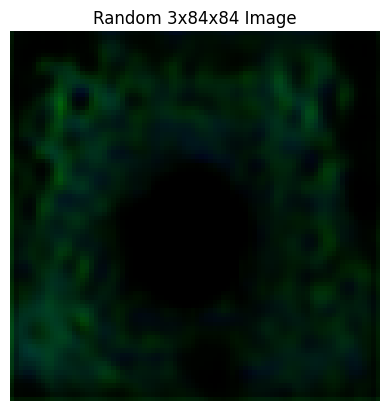

image_np
[[[-0.9998563  -0.81330717 -0.9633752 ]
  [-0.99999684 -0.95030785 -0.9795958 ]
  [-0.9999991  -0.95913327 -0.9835285 ]
  ...
  [-0.99999976 -0.97205985 -0.98367065]
  [-0.9999994  -0.9669142  -0.97884625]
  [-0.9999487  -0.8781161  -0.958837  ]]

 [[-0.9999982  -0.82077265 -0.9889636 ]
  [-1.         -0.9614201  -0.9959793 ]
  [-1.         -0.9634792  -0.99754727]
  ...
  [-1.         -0.982233   -0.99862885]
  [-1.         -0.9788052  -0.99746525]
  [-0.9999997  -0.9020078  -0.9932672 ]]

 [[-0.99999905 -0.8403739  -0.9920783 ]
  [-1.         -0.9678879  -0.9974028 ]
  [-1.         -0.96742713 -0.9984892 ]
  ...
  [-1.         -0.9863161  -0.9997257 ]
  [-1.         -0.983643   -0.9992852 ]
  [-0.99999994 -0.9152015  -0.99693114]]

 ...

 [[-0.99999815 -0.8213703  -0.9903633 ]
  [-1.         -0.95895475 -0.99456143]
  [-1.         -0.9538097  -0.9920338 ]
  ...
  [-1.         -0.92796826 -0.9937645 ]
  [-1.         -0.95399165 -0.9933939 ]
  [-0.99999917 -0.8713323  -0.98927

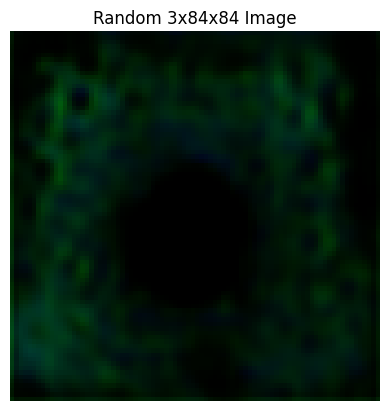

image_np
[[[-0.9998324  -0.81061006 -0.9601883 ]
  [-0.99999577 -0.94867927 -0.97646815]
  [-0.9999987  -0.9573278  -0.9805468 ]
  ...
  [-0.9999996  -0.9713088  -0.9851162 ]
  [-0.999999   -0.96546096 -0.97956234]
  [-0.9999256  -0.8768396  -0.9586788 ]]

 [[-0.99999785 -0.819517   -0.9879999 ]
  [-1.         -0.9600831  -0.9953065 ]
  [-1.         -0.9610784  -0.99701434]
  ...
  [-1.         -0.9803181  -0.9989475 ]
  [-1.         -0.9762048  -0.9977031 ]
  [-0.99999946 -0.89855766 -0.9931384 ]]

 [[-0.9999989  -0.84353936 -0.9919676 ]
  [-1.         -0.9675412  -0.99729097]
  [-1.         -0.9653072  -0.9983517 ]
  ...
  [-1.         -0.9843015  -0.9998141 ]
  [-1.         -0.98083526 -0.999368  ]
  [-0.9999998  -0.9113685  -0.9966863 ]]

 ...

 [[-0.9999975  -0.80668914 -0.98527616]
  [-1.         -0.9540078  -0.9895999 ]
  [-1.         -0.941699   -0.9843279 ]
  ...
  [-1.         -0.93424094 -0.992469  ]
  [-1.         -0.9545812  -0.9918043 ]
  [-0.999999   -0.8708919  -0.98730

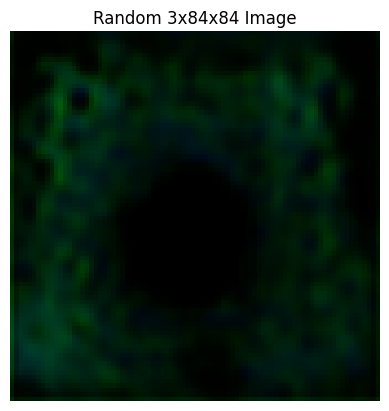

image_np
[[[-0.9998709  -0.8169435  -0.96390456]
  [-0.9999972  -0.9513457  -0.9798086 ]
  [-0.99999917 -0.958051   -0.9835716 ]
  ...
  [-0.99999946 -0.971794   -0.98487216]
  [-0.99999887 -0.9664308  -0.9788928 ]
  [-0.9999223  -0.88115054 -0.9567919 ]]

 [[-0.99999857 -0.830586   -0.9891332 ]
  [-1.         -0.9638371  -0.9960112 ]
  [-1.         -0.96276414 -0.9975457 ]
  ...
  [-1.         -0.9813609  -0.9991327 ]
  [-1.         -0.9776568  -0.9979458 ]
  [-0.99999946 -0.9052537  -0.9932379 ]]

 [[-0.99999934 -0.85335094 -0.9922467 ]
  [-1.         -0.97082394 -0.9974523 ]
  [-1.         -0.96707416 -0.9985013 ]
  ...
  [-1.         -0.9862006  -0.99991727]
  [-1.         -0.98313487 -0.99963665]
  [-0.99999976 -0.9214652  -0.99735475]]

 ...

 [[-0.9999959  -0.7912786  -0.9838212 ]
  [-1.         -0.94898546 -0.9881305 ]
  [-1.         -0.94071984 -0.9834615 ]
  ...
  [-1.         -0.9280365  -0.9912854 ]
  [-1.         -0.9501511  -0.99134296]
  [-0.9999984  -0.8638776  -0.98689

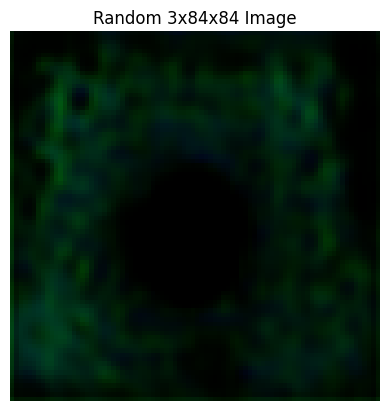

image_np
[[[-0.9998971  -0.83116347 -0.96343315]
  [-0.9999982  -0.95877147 -0.97985446]
  [-0.9999995  -0.96638685 -0.98448145]
  ...
  [-0.99999964 -0.97065866 -0.9822692 ]
  [-0.99999905 -0.96480256 -0.97588664]
  [-0.9999313  -0.87633103 -0.9530612 ]]

 [[-0.9999989  -0.84197176 -0.9893562 ]
  [-1.         -0.96932787 -0.99634093]
  [-1.         -0.9712174  -0.99802905]
  ...
  [-1.         -0.980691   -0.9987012 ]
  [-1.         -0.9762122  -0.9972429 ]
  [-0.9999995  -0.8983485  -0.9920425 ]]

 [[-0.99999946 -0.8582276  -0.99230087]
  [-1.         -0.9742613  -0.9976962 ]
  [-1.         -0.97474265 -0.9988783 ]
  ...
  [-1.         -0.9856599  -0.99980015]
  [-1.         -0.9817721  -0.99933285]
  [-0.9999998  -0.9126959  -0.99650365]]

 ...

 [[-0.999999   -0.8359871  -0.9905393 ]
  [-1.         -0.96494687 -0.99503624]
  [-1.         -0.9592865  -0.9935224 ]
  ...
  [-1.         -0.9358865  -0.990493  ]
  [-1.         -0.95684904 -0.990165  ]
  [-0.9999993  -0.87464494 -0.98543

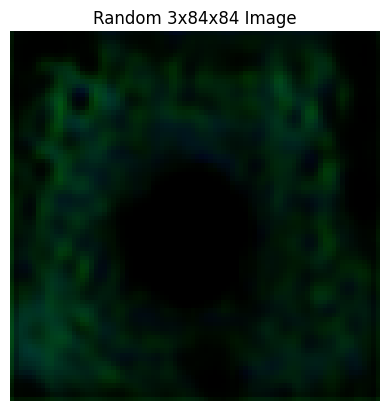

image_np
[[[-0.99986434 -0.82067275 -0.9628563 ]
  [-0.99999696 -0.9533247  -0.9791325 ]
  [-0.99999905 -0.96045214 -0.9833485 ]
  ...
  [-0.9999996  -0.9693262  -0.984739  ]
  [-0.9999989  -0.96432376 -0.9791138 ]
  [-0.99992645 -0.87537724 -0.95794916]]

 [[-0.9999984  -0.82998884 -0.98897386]
  [-1.         -0.9640274  -0.99600935]
  [-1.         -0.9643148  -0.9976209 ]
  ...
  [-1.         -0.9789718  -0.99887717]
  [-1.         -0.9756211  -0.9976164 ]
  [-0.99999946 -0.89761364 -0.99298036]]

 [[-0.99999917 -0.8491345  -0.9922119 ]
  [-1.         -0.9697401  -0.99751824]
  [-1.         -0.96765053 -0.9985911 ]
  ...
  [-1.         -0.9835075  -0.9998128 ]
  [-1.         -0.98080415 -0.9993816 ]
  [-0.9999998  -0.91142356 -0.99674195]]

 ...

 [[-0.99999857 -0.8282459  -0.99061745]
  [-1.         -0.96296746 -0.9949821 ]
  [-1.         -0.9592165  -0.993419  ]
  ...
  [-1.         -0.9220003  -0.98701495]
  [-1.         -0.9499997  -0.9875323 ]
  [-0.9999986  -0.86586714 -0.98341

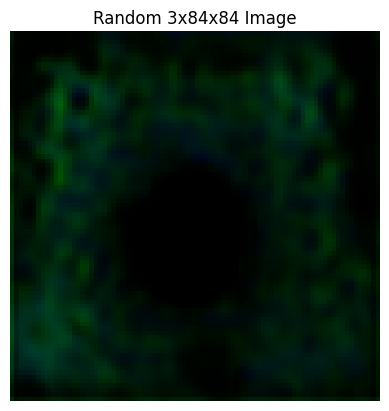

image_np
[[[-0.99987775 -0.82763195 -0.96363866]
  [-0.99999756 -0.9565665  -0.98056394]
  [-0.99999934 -0.9648574  -0.98526484]
  ...
  [-0.99999976 -0.9752868  -0.9868685 ]
  [-0.99999934 -0.968725   -0.98107666]
  [-0.9999432  -0.88199544 -0.95912623]]

 [[-0.9999986  -0.835576   -0.9894958 ]
  [-1.         -0.9662619  -0.99654144]
  [-1.         -0.9686767  -0.9981395 ]
  ...
  [-1.         -0.9845958  -0.9993406 ]
  [-1.         -0.97977096 -0.998392  ]
  [-0.9999997  -0.9053323  -0.99421954]]

 [[-0.9999993  -0.85208875 -0.9922374 ]
  [-1.         -0.971556   -0.997729  ]
  [-1.         -0.9724557  -0.9988567 ]
  ...
  [-1.         -0.98890615 -0.9999339 ]
  [-1.         -0.9848948  -0.99971956]
  [-0.9999999  -0.92063564 -0.9978783 ]]

 ...

 [[-0.99999744 -0.80213886 -0.9813519 ]
  [-1.         -0.9560736  -0.98497075]
  [-1.         -0.9496089  -0.9780427 ]
  ...
  [-1.         -0.93944675 -0.991282  ]
  [-1.         -0.9558601  -0.9912749 ]
  [-0.9999994  -0.86940825 -0.98682

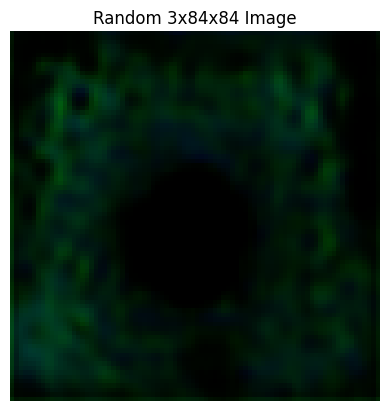

image_np
[[[-0.999833   -0.8086715  -0.9581333 ]
  [-0.9999962  -0.9491509  -0.9756    ]
  [-0.9999989  -0.9590881  -0.9811216 ]
  ...
  [-0.9999998  -0.9779501  -0.992245  ]
  [-0.99999946 -0.97200537 -0.98745406]
  [-0.99994963 -0.89012575 -0.9679963 ]]

 [[-0.9999977  -0.8146848  -0.9865458 ]
  [-1.         -0.96070886 -0.9946864 ]
  [-1.         -0.96427625 -0.99696887]
  ...
  [-1.         -0.98537374 -0.9997571 ]
  [-1.         -0.9815208  -0.9992778 ]
  [-0.99999976 -0.9127613  -0.99646616]]

 [[-0.9999987  -0.8328768  -0.99021935]
  [-1.         -0.96711904 -0.9965008 ]
  [-1.         -0.968789   -0.9981246 ]
  ...
  [-1.         -0.9888844  -0.9999813 ]
  [-1.         -0.9861086  -0.9998993 ]
  [-0.99999994 -0.9280974  -0.99886864]]

 ...

 [[-0.9999976  -0.8079386  -0.98678744]
  [-1.         -0.95626193 -0.99149597]
  [-1.         -0.9508945  -0.98878217]
  ...
  [-1.         -0.9286989  -0.9897547 ]
  [-1.         -0.95108116 -0.98951375]
  [-0.9999988  -0.8662863  -0.98466

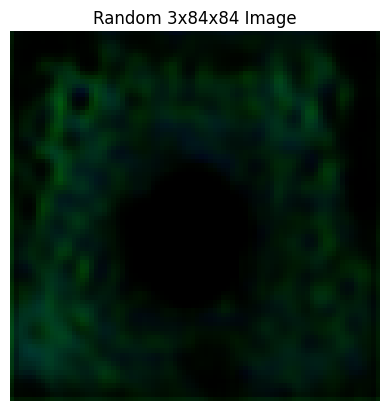

image_np
[[[-0.9998251  -0.80806756 -0.96242404]
  [-0.99999547 -0.946922   -0.97861385]
  [-0.99999857 -0.9557895  -0.9821937 ]
  ...
  [-0.99999976 -0.97384554 -0.98758864]
  [-0.99999946 -0.9683659  -0.9834554 ]
  [-0.9999509  -0.8803475  -0.9650544 ]]

 [[-0.9999976  -0.8156437  -0.98838425]
  [-1.         -0.9581788  -0.99560034]
  [-1.         -0.9594691  -0.99713504]
  ...
  [-1.         -0.98346263 -0.99919116]
  [-1.         -0.9799808  -0.9984305 ]
  [-0.99999976 -0.90470636 -0.9951683 ]]

 [[-0.9999987  -0.8344552  -0.99161047]
  [-1.         -0.9643165  -0.9971244 ]
  [-1.         -0.9626308  -0.99816895]
  ...
  [-1.         -0.9871961  -0.9998707 ]
  [-1.         -0.98470175 -0.9996387 ]
  [-0.99999994 -0.91865224 -0.998078  ]]

 ...

 [[-0.99999887 -0.8380687  -0.99019927]
  [-1.         -0.96417034 -0.9941726 ]
  [-1.         -0.9552827  -0.9913005 ]
  ...
  [-1.         -0.9169292  -0.9839126 ]
  [-1.         -0.9478991  -0.9849943 ]
  [-0.9999986  -0.8643584  -0.98115

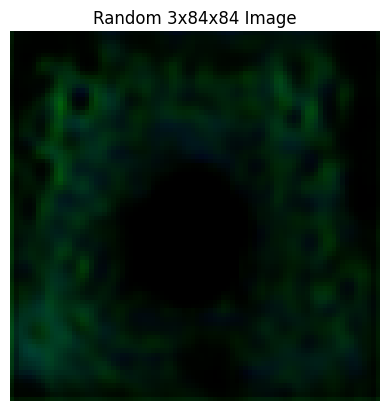

KeyboardInterrupt: 

In [30]:
train_data = maml_system.data.get_train_batches(total_batches=int(600/1), augment_images=False)

for sample_idx, train_sample in enumerate(train_data):
    
    x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample
    
    x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
    x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
    y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
    y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)
    
    for task_id, (x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task) in enumerate(zip(x_support_set,
                              y_support_set,
                              x_target_set,
                              y_target_set)):
        
        
        names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())

        num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

        names_weights_copy = {
            name.replace('module.', ''): value.unsqueeze(0).repeat(
                [num_devices] + [1 for i in range(len(value.shape))]) for
            name, value in names_weights_copy.items()}

        prompted_weights_copy = {}
        if args.prompter and args.prompt_engineering == 'arbiter':
            prompted_weights_copy = {key: value for key, value in names_weights_copy.items() if 'prompt' in key}

        names_weights_copy = {key: value for key, value in names_weights_copy.items() if 'layer_dict' in key}
        
        n, s, c, h, w = x_target_set_task.shape

        x_support_set_task = x_support_set_task.view(-1, c, h, w)
        y_support_set_task = y_support_set_task.view(-1)
        x_target_set_task = x_target_set_task.view(-1, c, h, w)
        y_target_set_task = y_target_set_task.view(-1)
                
        z = nn.Parameter(torch.randn([args.num_text_embedding_params]), requires_grad=True).to(maml_system.model.device)
        
        for num_step in range(5):
            
            # layerwise_mean_weights = []
            # for k, v in names_weights_copy.items():
            #     layerwise_mean_weights.append(v.mean())

            # condition = torch.stack(layerwise_mean_weights)
            # task_embedding = torch.cat([z, condition], dim=0)
            # task_embedding = task_embedding.unsqueeze(0)
            # ideal_prompt = self.arbiter(task_embedding)
            ideal_prompt = self.arbiter(z)
            prompted_weights_copy['prompt.prompt_dict.arbiter'] = ideal_prompt
            

            support_loss, support_preds, _ = maml_system.model.net_forward(
              x=x_support_set_task,
              y=y_support_set_task,
              weights=names_weights_copy,
              prompted_weights=prompted_weights_copy,
              backup_running_statistics=num_step == 0,
              training=True,
              num_step=num_step,
              training_phase=False,
              epoch=0)
            
            gradients = torch.autograd.grad(support_loss, (*names_weights_copy.values(), z),
                                                create_graph=True, retain_graph=True)

            grads, context_grads = gradients[:-1], gradients[-1]
            
            
#             print("num_step == ", num_step)
#             weights_norms = [torch.norm(w, p=2) for w in names_weights_copy.values()]
#             print("weights_norms:", weights_norms)
            
#             # grads의 norm 계산 (각 gradient 텐서의 norm을 개별적으로 계산)
#             grads_norms = [torch.norm(g, p=2) for g in grads]
#             # context_grads의 norm 계산
#             context_grads_norm = torch.norm(context_grads, p=2)
#             print("Norms of grads:", grads_norms)
#             print("Norm of context_grads:", context_grads_norm)
            
            
            image_np = ideal_prompt.detach().cpu().squeeze().permute(1, 2, 0).numpy()
            z = z - args.text_embedding_learning_rate * context_grads
            
            names_weights_copy = maml_system.model.apply_inner_loop_update(
             loss=support_loss,
             names_weights_copy=names_weights_copy,
             use_second_order=True,
             current_step_idx=num_step,
             current_iter='test',
             training_phase=False)

            
#             prompted_images = maml_system.model.classifier.prompt(x=x_support_set_task, prompted_params=prompted_weights_copy)
#             basic.show_batch(images=prompted_images, labels=y_support_set_task, datasets=datasets)
            
            if num_step == 4:
                
                # layerwise_mean_weights = []
                # for k, v in names_weights_copy.items():
                #     layerwise_mean_weights.append(v.mean())

                # condition = torch.stack(layerwise_mean_weights)
                # task_embedding = torch.cat([z, condition], dim=0)
                # task_embedding = task_embedding.unsqueeze(0)
                # ideal_prompt = self.arbiter(task_embedding)
                ideal_prompt = self.arbiter(z)
                prompted_weights_copy['prompt.prompt_dict.arbiter'] = ideal_prompt
                
                
                print("image_np")
                print(image_np)

                # Plot the image
#                 plt.imshow((image_np + 1)/2)
#                 plt.axis('off')  # Turn off the axes for better visualization
#                 plt.title("Random 3x84x84 Image")
#                 plt.show()
                
                
                target_loss, target_preds, prompt_feature_map = maml_system.model.net_forward(
                    x=x_target_set_task,
                    y=y_target_set_task,
                    weights=names_weights_copy,
                    prompted_weights=prompted_weights_copy,
                    backup_running_statistics=False, training=True,
                    num_step=num_step,
                    training_phase=False,
                    epoch=0)
                
                